In [7]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import Delaunay
from sklearn.metrics.pairwise import euclidean_distances
import math
from scipy.spatial import ConvexHull
import torch
import itertools

# General overview

Хитрый план:

1)

2)

# Laplace-Beltrami operator generation

The Laplace-Beltrami operator generation consists of the following significant steps.

* $\mathbf{Mesh~triangulation}$

For a given mesh of points we obtain a triangulation via applying Delaunay method at the first step of the operator generation. From this point further the triangulation is fixed.

* $\mathbf{Obtaining~interior~and~boundary~edges}$

The generation algorithm requires interior and boundary edges ($E_i$ and $E_b$) separately, so we obtain them with the help of convex hull, since we consider only convex shapes as input.

* $\mathbf{Pairwise~distances}$

On the next step we calculate matrix of pairwise distances $L$ (with elements $l_{ij}$) for the points connected with an edge.

* $\mathbf{Triangles~areas}$

For every point we find one third of the area of all the triangles that contain this point. The area is shown in green in the figure below.

![title](p.jpg)

The diagonal matrix containing these areas on the diagonal is denoted as $A$ with elements $A_i$. $A_{ijk}$ denote the area of the triangle set by points $i$, $j$ and $k$.

* $\mathbf{Edge\textbf{-}wise~weight~matrix}$

The element-wise weight matrix is denoted as $\mathbf{W}$ and its elements are set as follows:

![title](pp.jpg)

* $\mathbf{Laplace-Beltrami~operator}$

Finally, the Laplace-Beltrami operator is $\mathbf{\Delta} = \mathbf{A}^{-1} \mathbf{W}$

In [ ]:
def calc_L(points, simplices):
    #simplices = Delaunay (points).simplices
    #distances = euclidean_distances (points, points)
    
    L = torch.zeros((len(points), len(points)))

    for sim in simplices:
        for ind in [[0, 1], [1, 2], [0, 2]]:
            #L [sim [ind [0]], sim [ind [1]]] = distances [sim [ind [0]], sim [ind [1]]]
            #L [sim [ind [1]], sim [ind [0]]] = distances [sim [ind [1]], sim [ind [0]]]
            L [sim [ind [0]], sim [ind [1]]] = ((points[sim [ind [0]]][0]-points[sim [ind [1]]][0])**2+\
                                               (points[sim [ind [0]]][1]-points[sim [ind [1]]][1])**2)**0.5
            L [sim [ind [1]], sim [ind [0]]] = ((points[sim [ind [0]]][0]-points[sim [ind [1]]][0])**2+\
                                               (points[sim [ind [0]]][1]-points[sim [ind [1]]][1])**2)**0.5

    return L

def calc_triangle_area(L, i1, i2, i3):
    l1 = L [i1, i2]
    l2 = L [i2, i3]
    l3 = L [i3, i1]

    p = (l1 + l2 + l3) / 2

    return math.sqrt (p * (p - l1) * (p - l2) * (p - l3))

def calc_A (simplices, L, points_num):
    A = torch.zeros ((points_num, points_num))
    
    for i in range (points_num):
        area = 0
        
        for j in range (len (simplices)):
            if (i in simplices [j]):
                sim = simplices [j]
                
                area_part = calc_triangle_area (L, sim [0], sim [1], sim [2])
                
                area += area_part / 3
        
        A [i, i] = area
    
    return A

def find_E_Eb (points, simplices):
    E = []
    
    for sim in simplices:
        E.append (sorted ((sim [0], sim [1])))
        E.append (sorted ((sim [1], sim [2])))
        E.append (sorted ((sim [2], sim [0])))
    
    E_b = []
    hull = ConvexHull (points).vertices
    
    for i in range (len (hull) - 1):
        E_b.append (sorted ((hull [i], hull [i + 1])))
    
    E_b.append (sorted ((hull [0], hull [-1])))
    
    #АЛАРМА
    #Тут нужно оставить в E и E_b только уникальные таплы.
    #Я попробовал это сделать, но с unhashable type какая-то морока, так то я забил.
    #В этом месте числа внутри тапла отсортированы.
    #Пробовал вот таким образом:
    #return list (set (E)), list (set (E_b))
    
    return E, E_b

def calc_W (E, E_b, A, L, simplices):
    W = torch.zeros (A.shape)
    
    sh = W.shape
    
    for i in range (sh [0]):
        for j in range (i + 1, sh [0]):
            kh_list = []
    
            for sim in simplices:
                elem = set (sim)                
                ele = set ([i, j])
                
                #print ("ele, elem")
                #print (ele, elem)
                
                if (ele.issubset (elem)):
                    kh_list.append (elem.difference (ele))
            
            if (len (kh_list) == 0):
                continue
            
            h = list (kh_list [0]) [0]
            
            if ([i, j] in E and [i, j] not in E_b):
                k = list (kh_list [1]) [0]
                
                val = 0
                
                val += (- L [i, j]**2 + L [j, k]**2 + L [k, i]**2) / \
                    (8 * calc_triangle_area (L, i, j, k))

                val += (- L [i, j]**2 + L [j, h]**2 + L [h, i]**2) / \
                    (8 * calc_triangle_area (L, i, j, h))
                
                W [i, j] = val
                
            elif ([i, j] in E_b):
                val = 0
                
                val += (- L [i, j]**2 + L [j, h]**2 + L [h, i]**2) / \
                    (8 * calc_triangle_area (L, i, j, h))
                
                W [i, j] = val
        
    for i in range (sh [0]):
        for j in range (i, sh [0]):
            W [j] [i] = W [i] [j]
    
    for i in range (sh [0]):
        W [i, i] = - sum (W [i, :])

    return W


# Shapes generation

This section contains generation of the random point mesh and circlic mesh with evenly distributed points.

In [ ]:
def plot_triangulation (points, triang):
    plt.triplot (points[:,0], points[:,1], triang)
    plt.plot (points[:,0], points[:,1], 'o')
    plt.show()

def plot_mesh (mesh):
    plt.plot (mesh [:, 0], mesh [:, 1], 'o')
    plt.show()

def generate_circle (x, y, r, num, num_interior=0):
    circle = np.zeros ((num + num_interior, 2), np.float64)
    
    for i in range (num):
        angle = math.pi * 2 / num * i
        
        circle [i, 0] = x + r * math.cos (angle)
        circle [i, 1] = y + r * math.sin (angle)
    
    for i in range (num_interior):
        px = 0
        py = 0
        
        while (True):
            px = np.random.rand (1)
            py = np.random.rand (1)
            
            if ((px - 0.5)**2 + (py - 0.5)**2 < 0.25):
                break
        
        px = x + px * 2 * r - r
        py = y + py * 2 * r - r
        
        circle [num + i, 0] = px
        circle [num + i, 1] = py

    return circle

def generate_random_mesh (num):
    mesh = np.random.rand (num, 2)
    
    return mesh

circle = generate_circle (0, 1, 1, 20, num_interior=40)
plot_mesh (circle)

rand_mesh = generate_random_mesh (15)
plot_mesh (rand_mesh)

#Немного о том, почему функция генерации кружочка именно такая.
#В ней отдельно задается количество внешних точек и отдельно количество внутренних.
#Это нужно, чтобы после генерации рандомного меша получить количество граничных точек
#в нем и создать кружочек с таким же количеством граничных точек. Это будет означать,
#что количество граничных ребер в множествах тоже совпадает. Насколько я понимаю, это
#необходимо, потому что если рандомный меш состоит из четырех точек - треугольника и
#одной внутренней, то приближать его, начиная с квадрата, было бы странно.

# Eigenvalues calculation

Since we needed to calculate eigenvalues and eigenvectors with an ability to propagate the gradients back, below is the implementation of the Modified Gram-Schmidt QR decomposition in TensorFlow.

In [ ]:
def modified_gram_schmidt_qr(A): # 5 pts
    assert A.shape[0] >= A.shape[1], 'm is not >= n'
    new_vectors = torch.zeros(A.shape)
    for i in range(A.shape[1]):
        new_vectors[:,i] += A[:,i]
        if i > 0:
            new_vectors[:,i] -= torch.tensor(((A[:,i] @ new_vectors[:,0])/(new_vectors[:,0] @ new_vectors[:,0])) * new_vectors[:,0])
        
        for j in range(1,i):
            new_vectors[:,i] -= torch.tensor(((new_vectors[:,i] @ new_vectors[:,j])/(new_vectors[:,j] @ new_vectors[:,j])) * new_vectors[:,j])
        
    # normalization
    for i in range(new_vectors.shape[1]):
        new_vectors[:,i] /= torch.tensor(new_vectors[:,i]).norm()
    Q = new_vectors
    R = torch.zeros((A.shape[1],A.shape[1]))
    for i in range(A.shape[1]):
        for j in range(i, A.shape[1]):
            R[i,j] += A[:,j] @ new_vectors[:,i]
    return Q, R

def qralgo(a):
    while torch.sqrt(torch.sum(a.tril(-1)-1)) > 1e-9: 
        q,r = modified_gram_schmidt_qr(a) 
        a = r @ q
    return a

def eigvals(a):
    return qralgo(a).diag()


def find_eigenvalues (W, A):
    product = torch.inverse (A) @ W
    
    #lambdas, vectors = tuple (torch.symeig (product, eigenvectors=True))
    lambdas = eigvals(product)
    
    return lambdas


# Metric and penalty

The metric for the spectrums is a modified $l_2$ distance, weighted so that smaller eigenvalues are more important than the bigger ones during the optimization process.

Authors propose usage of composite penalty, consisting of two components: first is a smoothness-providing term and second is a preservation from triangles flips.

In [ ]:
def cut (val):
    return (min (0, val))**2

def rho (V, L, E_b, simplices):
    rho_1 = 0
    
    for e in E_b:
        rho_1 += L [e [0], e [1]]**2
    
    rho_2 = 0
    
    for s in simplices:
        for sim in list(itertools.permutations(s)):

            rot_matr = torch.tensor ([[0., -1.], [1., 0.]])
            sub_1 = V [sim [1]] - V [sim [0]]
            sub_2 = V [sim [2]] - V [sim [0]]

            curr_val = (rot_matr @ sub_1).transpose(0, -1) @ sub_2

            rho_2 += curr_val
    
    rho = rho_1 + cut (rho_2)
    
    return rho

def weighted_norm (a, b):
    norm = 0.0
    
    for i in range (len (a)):
        norm += (a [i] - b [i])**2 / (i + 1)
    
    return norm

# Experiment



In [9]:
target = [(0.0, 0.0), (1.0, 0.0), (2.0, 1.0), (0.0, 1.0)]
tri = Delaunay(target)
simplices = tri.simplices
E, E_b = find_E_Eb (target, simplices)
target_points = torch.tensor(target)
L = calc_L(target_points, simplices)
A = calc_A(simplices, L, len (target_points))
W = calc_W(E, E_b, A, L, simplices)
mu = find_eigenvalues (W, A)

initial = [(0.0, 0.0), (1.0, 0.0), (1.0, 1.0), (0.0, 1.0)]

tri = Delaunay(initial)
simplices = tri.simplices
E, E_b = find_E_Eb (initial, simplices)

points = torch.tensor(initial, requires_grad=True)
optimizer = torch.optim.Adam([points], lr = 0.0001)

print("Target: {}".format(mu))

for _ in range(2000):
    L = calc_L (points, simplices)
    A = calc_A (simplices, L, len (points))
    W = calc_W (E, E_b, A, L, simplices)
    pen = rho (points, L, E_b, simplices)
    
    current_eigen = find_eigenvalues(W, A)
    
    #loss =   weighted_norm(current_eigen, mu)+pen# calculate loss
    loss =   weighted_norm(current_eigen, mu)#+pen# calculate loss
    #print (mu)
    optimizer.zero_grad()  # clear previous gradients
    loss.backward()        # compute gradients of all variables wrt loss

    optimizer.step()
    if _ % 25 == 0:
        print(current_eigen)
        print(loss)
    

Target: tensor([-6.0000, -3.0000, -1.5000, -2.0000])
tensor([-6.0000, -3.0000, -6.0000, -3.0000], grad_fn=<DiagBackward>)
tensor(7.0000, grad_fn=<AddBackward0>)
tensor([-6.0608, -3.0303, -6.0611, -3.0305], grad_fn=<DiagBackward>)
tensor(7.2042, grad_fn=<AddBackward0>)
tensor([-6.1329, -3.0618, -6.1332, -3.0667], grad_fn=<DiagBackward>)
tensor(7.4595, grad_fn=<AddBackward0>)
tensor([-6.2118, -3.0946, -6.2121, -3.1066], grad_fn=<DiagBackward>)
tensor(7.7567, grad_fn=<AddBackward0>)
tensor([-6.2957, -3.1291, -6.2961, -3.1492], grad_fn=<DiagBackward>)
tensor(8.0933, grad_fn=<AddBackward0>)
tensor([-6.3841, -3.1652, -6.3844, -3.1942], grad_fn=<DiagBackward>)
tensor(8.4702, grad_fn=<AddBackward0>)
tensor([-6.4766, -3.2031, -6.4769, -3.2416], grad_fn=<DiagBackward>)
tensor(8.8897, grad_fn=<AddBackward0>)
tensor([-6.5732, -3.2428, -6.5735, -3.2912], grad_fn=<DiagBackward>)
tensor(9.3551, grad_fn=<AddBackward0>)
tensor([-6.6740, -3.2845, -6.6743, -3.3431], grad_fn=<DiagBackward>)
tensor(9.8703,

/home/kefir/miniconda3/envs/zenv/lib/python3.7/site-packages/ipykernel_launcher.py:144: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/kefir/miniconda3/envs/zenv/lib/python3.7/site-packages/ipykernel_launcher.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/kefir/miniconda3/envs/zenv/lib/python3.7/site-packages/ipykernel_launcher.py:151: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


tensor([-16.6850, -12.7051,  -9.4712,  -6.5410], grad_fn=<DiagBackward>)
tensor(187.5996, grad_fn=<AddBackward0>)
tensor([-13.0338,  -5.9466, -13.0356,  -6.7093], grad_fn=<DiagBackward>)
tensor(103.7165, grad_fn=<AddBackward0>)
tensor([-13.0327,  -5.9386, -13.0345,  -6.7096], grad_fn=<DiagBackward>)
tensor(103.6698, grad_fn=<AddBackward0>)
tensor([-13.0326,  -5.9381, -13.0345,  -6.7097], grad_fn=<DiagBackward>)
tensor(103.6667, grad_fn=<AddBackward0>)
tensor([-13.0326,  -5.9380, -13.0344,  -6.7097], grad_fn=<DiagBackward>)
tensor(103.6663, grad_fn=<AddBackward0>)
tensor([-13.0326,  -5.9380, -13.0344,  -6.7097], grad_fn=<DiagBackward>)
tensor(103.6663, grad_fn=<AddBackward0>)
tensor([-13.0326,  -5.9380, -13.0344,  -6.7097], grad_fn=<DiagBackward>)
tensor(103.6663, grad_fn=<AddBackward0>)
tensor([-13.0326,  -5.9380, -13.0344,  -6.7097], grad_fn=<DiagBackward>)
tensor(103.6663, grad_fn=<AddBackward0>)
tensor([-13.0326,  -5.9380, -13.0344,  -6.7097], grad_fn=<DiagBackward>)
tensor(103.6663

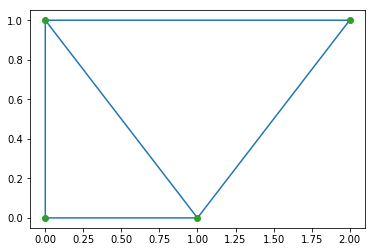

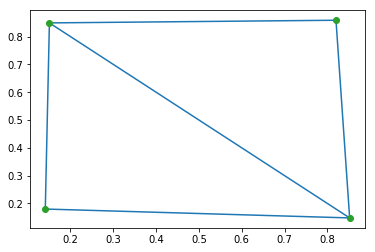

In [13]:
plot_triangulation(target_points.detach().numpy(), simplices)
plot_triangulation(points.detach().numpy(), simplices)